In [1]:
import os
import librosa
from pydub import AudioSegment
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from random import sample
from tqdm import tqdm
import numpy as np
import pandas as pd
import random
import re


Bad key "text.kerning_factor" on line 4 in
/home/fstovarr/anaconda3/envs/birds/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


# Data processing

In [2]:
!ls audios/
!pwd

audios.zip  metadata.csv  mp3  wav
/home/fstovarr/birds


In [3]:
WAV_PATH = "/home/fstovarr/birds/audios/wav"
MP3_PATH = "/home/fstovarr/birds/audios/mp3"

In [4]:
wav_files = os.listdir(WAV_PATH)
mp3_files = os.listdir(MP3_PATH)

FILENAME = "data.csv"

PREPROCESSING = False

# Important only if PREPROCESSING is True
SAMPLES = len(wav_files)
THREADS = 8

In [5]:
def espectrogram(x):
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    return Xdb

def spectral_centroid(x, sr):
    return librosa.feature.spectral_centroid(x, sr=sr)[0]

def spectral_rolloff(x, sr):
    return librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]

def spectral_bandwidth(x, sr):
    spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr)[0]
    spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=3)[0]
    spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=4)[0]
    return (spectral_bandwidth_2, spectral_bandwidth_3, spectral_bandwidth_4)

def zero_crossing_rate(x, sr, n0 = 9000, n1 = 9100):
    return librosa.zero_crossings(x[n0:n1], pad=False)

def mel_frequency(x, sr):
    return librosa.feature.mfcc(x, sr=sr)

def chroma(x, sr):
    return librosa.feature.chroma_stft(x, sr=sr)

In [6]:
random.shuffle(wav_files)
wav_files

['Caprimulgus-europaeus-481986.wav',
 'Luscinia-luscinia-104377.wav',
 'Phylloscopus-sibilatrix-134220.wav',
 'Ficedula-parva-134676.wav',
 'Phylloscopus-collybita-131387.wav',
 'Hirundo-rustica-195227.wav',
 'Linaria-cannabina-421682.wav',
 'Linaria-cannabina-470878.wav',
 'Athene-noctua-306574.wav',
 'Emberiza-schoeniclus-511910.wav',
 'Cyanistes-caeruleus-121313.wav',
 'Aegolius-funereus-508096.wav',
 'Emberiza-cirlus-246592.wav',
 'Parus-major-168924.wav',
 'Cuculus-canorus-420632.wav',
 'Acrocephalus-palustris-194054.wav',
 'Alauda-arvensis-168330.wav',
 'Sylvia-communis-142078.wav',
 'Athene-noctua-385240.wav',
 'Crex-crex-481574.wav',
 'Fringilla-coelebs-176831.wav',
 'Luscinia-luscinia-135787.wav',
 'Acrocephalus-dumetorum-247643.wav',
 'Phoenicurus-phoenicurus-180825.wav',
 'Caprimulgus-europaeus-323841.wav',
 'Acrocephalus-schoenobaenus-142462.wav',
 'Turdus-philomelos-185874.wav',
 'Sonus-naturalis-411631.wav',
 'Sylvia-borin-198644.wav',
 'Glaucidium-passerinum-344245.wav',

In [7]:
len(np.unique(np.array(wav_files)))

2150

In [8]:
wav_files = wav_files[0:SAMPLES]

In [9]:
import threading
from math import ceil

In [10]:
def process_data(processed_data, files):
    for file in tqdm(files):
        try:
            x, sr = librosa.load("{}/{}".format(WAV_PATH, file), sr=None)
        except Exception as e:
            print(e, "ERROR WITH FILE {}".format(file))
            continue
        
        tmp = []

        class_name = re.search('([A-za-z-]+)-[0-9]+.mp3', file).group(1).lower()

        np_fft = np.fft.fft(x)
        amplitudes = 2/len(x) * np.abs(np_fft)
        tmp.append(file)
        tmp.append(class_name)

        features = [x,amplitudes,spectral_centroid(x, sr),  spectral_rolloff(x, sr),  spectral_bandwidth(x, sr),  mel_frequency(x, sr),  chroma(x, sr)]

        for f in features:
            tmp.append(np.mean(f))
            tmp.append(np.max(f))
            tmp.append(np.min(f))
            tmp.append(np.std(f))

        tmp.append(sum(zero_crossing_rate(x, sr)))
        
        csv = open(FILENAME, "a+")
        csv.write(",".join(map(str, tmp)) + "\n")
        csv.close()

In [11]:
if PREPROCESSING:
    threads = THREADS
    chunk_size = ceil(len(wav_files) / threads)
    jobs = []


    out_list = [[] for i in range(threads)]

    for i in range(0, threads):
        thread = threading.Thread(target=process_data, args=(out_list[i], wav_files[chunk_size * i : min(chunk_size * i + chunk_size, len(wav_files))]))
        jobs.append(thread)

    for j in jobs:
        j.start()

    for j in jobs:
        j.join()

In [12]:
if PREPROCESSING:
    ol = np.array(out_list)
    sz = ol.shape
    processed_data = ol.reshape((sz[0] * sz[1], sz[2]))
    print(processed_data.shape)

In [13]:
feature_names = [
    'filename',
    'class_name', 
    'wave_min', 
    'wave_max', 
    'wave_mean', 
    'wave_var', 
    'amp_min', 
    'amp_max', 
    'amp_mean', 
    'amp_var', 
    'spectral_centroid_min', 
    'spectral_centroid_max', 
    'spectral_centroid_mean', 
    'spectral_centroid_var', 
    'spectral_rolloff_min', 
    'spectral_rolloff_max', 
    'spectral_rolloff_mean', 
    'spectral_rolloff_var', 
    'spectral_bandwidth_min', 
    'spectral_bandwidth_max', 
    'spectral_bandwidth_mean', 
    'spectral_bandwidth_var', 
    'mel_frequency_min', 
    'mel_frequency_max', 
    'mel_frequency_mean', 
    'mel_frequency_var', 
    'chroma_min', 
    'chroma_max', 
    'chroma_mean', 
    'chroma_var',
    'zero_crossing_rate'
 ]

# Neuronal Network

In [14]:
from PIL import Image
import pathlib
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras
from keras import layers, callbacks, Input, regularizers
from keras.models import Sequential
import seaborn as sns
from sklearn.metrics import confusion_matrix, recall_score, f1_score
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
def plot_confusion_matrix(y_true, y_pred, labels, filename=None, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    
    print(ymap, y_true)
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap=plt.cm.Blues)
    if filename != None:
        plt.savefig(filename)

In [16]:
data = pd.read_csv(FILENAME, names=feature_names)
data.head()

,filename,class_name,wave_min,wave_max,wave_mean,wave_var,amp_min,amp_max,amp_mean,amp_var,...,spectral_bandwidth_var,mel_frequency_min,mel_frequency_max,mel_frequency_mean,mel_frequency_var,chroma_min,chroma_max,chroma_mean,chroma_var,zero_crossing_rate
0,Hippolais-icterina-476939.wav,hippolais-icterina,-1.113427e-08,0.383163,-0.377548,0.023721,0.000013,0.000871,1.312748e-11,0.000029,...,1064.806047,-20.178236,158.12755,-688.75280,97.804085,0.415917,1.0,0.000000,0.324690,30
1,Erithacus-rubecula-507515.wav,erithacus-rubecula,-7.185017e-07,0.354980,-0.277756,0.014373,0.000007,0.000736,4.348848e-10,0.000015,...,1487.743074,-7.473933,194.46820,-697.81610,103.053085,0.564978,1.0,0.002361,0.263052,0
2,Linaria-cannabina-421682.wav,linaria-cannabina,-1.354322e-07,0.122467,-0.110748,0.007988,0.000004,0.000752,1.095046e-11,0.000008,...,765.846071,-11.453087,182.59860,-839.49370,99.838646,0.538127,1.0,0.000000,0.263558,5
3,Acrocephalus-arundinaceus-267178.wav,acrocephalus-arundinaceus,-3.773617e-06,0.109802,-0.110748,0.008166,0.000006,0.000281,3.841685e-11,0.000013,...,981.473644,-16.182085,193.25336,-786.07043,99.855896,0.481109,1.0,0.000000,0.294839,4
4,Troglodytes-troglodytes-361386.wav,troglodytes-troglodytes,6.800663e-08,0.100281,-0.099228,0.009322,0.000003,0.000139,5.058323e-12,0.000007,...,813.128931,-24.728077,154.04565,-797.11957,120.148170,0.419511,1.0,0.000000,0.325191,9


In [17]:
data.describe()

,wave_min,wave_max,wave_mean,wave_var,amp_min,amp_max,amp_mean,amp_var,spectral_centroid_min,spectral_centroid_max,...,spectral_bandwidth_var,mel_frequency_min,mel_frequency_max,mel_frequency_mean,mel_frequency_var,chroma_min,chroma_max,chroma_mean,chroma_var,zero_crossing_rate
count,2.149000e+03,2149.000000,2149.000000,2149.000000,2.149000e+03,2149.000000,2.149000e+03,2.149000e+03,2149.000000,2149.000000,...,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.0,2149.000000,2149.000000,2149.000000
mean,1.830183e-05,0.497655,-0.495932,0.034685,1.113358e-05,0.001669,1.537096e-10,3.166536e-05,4401.037542,8903.743132,...,1164.243239,-18.174330,150.253539,-614.884811,101.066018,0.467300,1.0,0.000861,0.308161,12.729642
std,2.907615e-03,0.298679,0.297057,0.027407,1.055213e-05,0.006128,1.091974e-09,2.989292e-05,1677.455003,2540.135551,...,339.880978,8.376168,41.251948,110.230750,17.052489,0.115016,0.0,0.007758,0.029249,11.318068
min,-7.980286e-02,0.005524,-1.000000,0.000592,1.404004e-07,0.000009,1.185175e-13,1.985936e-07,505.126886,2198.610378,...,204.812127,-43.320488,37.222942,-1116.870400,39.871666,0.030386,1.0,0.000000,0.088463,0.000000
25%,-7.889103e-06,0.242203,-0.730942,0.013978,4.127073e-06,0.000310,5.526418e-12,1.181603e-05,3309.515343,7073.671252,...,922.866439,-25.442324,125.062290,-682.739100,90.941530,0.385124,1.0,0.000000,0.295967,3.000000
50%,3.458461e-09,0.454559,-0.453888,0.028368,8.288598e-06,0.000638,1.259757e-11,2.351819e-05,4187.345866,8470.169620,...,1138.064463,-16.844128,149.875060,-605.600700,101.387924,0.453864,1.0,0.000008,0.314047,12.000000
75%,3.868654e-06,0.735641,-0.243881,0.048055,1.475062e-05,0.001325,3.555970e-11,4.215695e-05,5301.689604,10678.900625,...,1369.293316,-11.646959,173.624530,-541.503000,112.174706,0.543266,1.0,0.000065,0.325210,19.000000
max,4.562935e-02,0.999969,-0.000061,0.252685,1.368002e-04,0.159606,2.661194e-08,3.267286e-04,14572.508831,18536.294772,...,2573.315268,6.663881,320.503900,-214.406220,169.274700,0.908558,1.0,0.199908,0.398264,76.000000


In [18]:
birds_classes = data.iloc[:, 1]
class_names = birds_classes.unique()
class_names

array(['hippolais-icterina', 'erithacus-rubecula', 'linaria-cannabina',
       'acrocephalus-arundinaceus', 'troglodytes-troglodytes',
       'emberiza-hortulana', 'phoenicurus-phoenicurus',
       'emberiza-calandra', 'luscinia-svecica', 'turdus-philomelos',
       'ficedula-hypoleuca', 'cuculus-canorus', 'sylvia-atricapilla',
       'locustella-naevia', 'bubo-bubo', 'emberiza-cirlus',
       'caprimulgus-europaeus', 'carduelis-carduelis', 'strix-aluco',
       'pyrrhula-pyrrhula', 'emberiza-schoeniclus',
       'phylloscopus-sibilatrix', 'phylloscopus-collybita',
       'sylvia-borin', 'hirundo-rustica', 'fringilla-coelebs',
       'luscinia-luscinia', 'carpodacus-erythrinus',
       'glaucidium-passerinum', 'sonus-naturalis',
       'luscinia-megarhynchos', 'oriolus-oriolus', 'sylvia-communis',
       'chloris-chloris', 'acrocephalus-schoenobaenus',
       'loxia-curvirostra', 'emberiza-citrinella', 'alauda-arvensis',
       'phylloscopus-trochilus', 'athene-noctua', 'parus-major',


In [19]:
len(data.iloc[:, 1].unique())

50

In [20]:
data.groupby('class_name').size()

class_name
acrocephalus-arundinaceus     43
acrocephalus-dumetorum        43
acrocephalus-palustris        43
acrocephalus-schoenobaenus    43
aegolius-funereus             43
alauda-arvensis               43
athene-noctua                 43
bubo-bubo                     43
caprimulgus-europaeus         43
carduelis-carduelis           43
carpodacus-erythrinus         43
chloris-chloris               43
crex-crex                     43
cuculus-canorus               43
cyanistes-caeruleus           43
emberiza-calandra             43
emberiza-cirlus               43
emberiza-citrinella           43
emberiza-hortulana            43
emberiza-schoeniclus          43
erithacus-rubecula            43
ficedula-hypoleuca            43
ficedula-parva                43
fringilla-coelebs             43
glaucidium-passerinum         43
hippolais-icterina            43
hirundo-rustica               43
linaria-cannabina             43
locustella-naevia             43
loxia-curvirostra             42

In [21]:
import colorsys

N = len(class_names)
HSV_tuples = [(x*1.0/N, 0.5, 0.5) for x in range(N)]
RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
colors = list(RGB_tuples)

In [22]:
dict_classes = {}
for i, b in enumerate(class_names):
    dict_classes[b] = i

sm_colors = [colors[dict_classes[c]] for c in birds_classes]

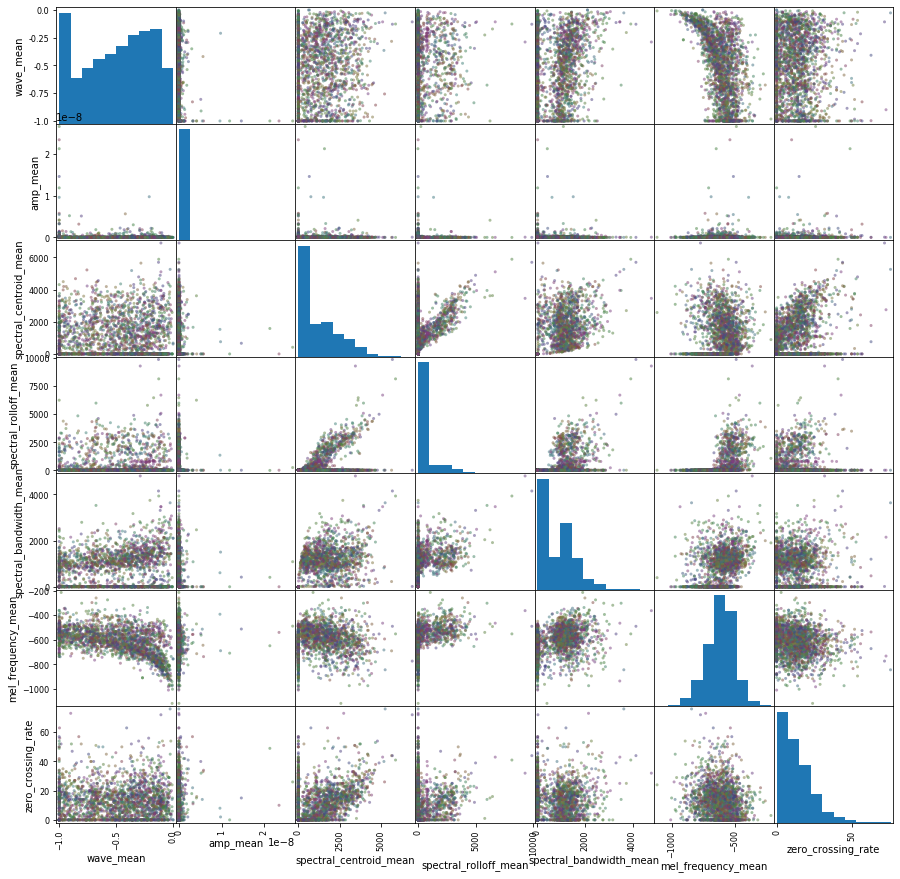

In [23]:
_ = pd.plotting.scatter_matrix(data[[
    'wave_mean', 
    'amp_mean', 
    'spectral_centroid_mean', 
    'spectral_rolloff_mean', 
    'spectral_bandwidth_mean', 
    'mel_frequency_mean', 
    'zero_crossing_rate'
]], c=sm_colors, figsize=(15, 15))

/home/fstovarr/anaconda3/envs/birds/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/fstovarr/anaconda3/envs/birds/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/fstovarr/anaconda3/envs/birds/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/fstovarr/anaconda3/envs/birds/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/fstovarr/anaconda3/envs/birds/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/fstovarr/anaconda3/envs/birds/lib/

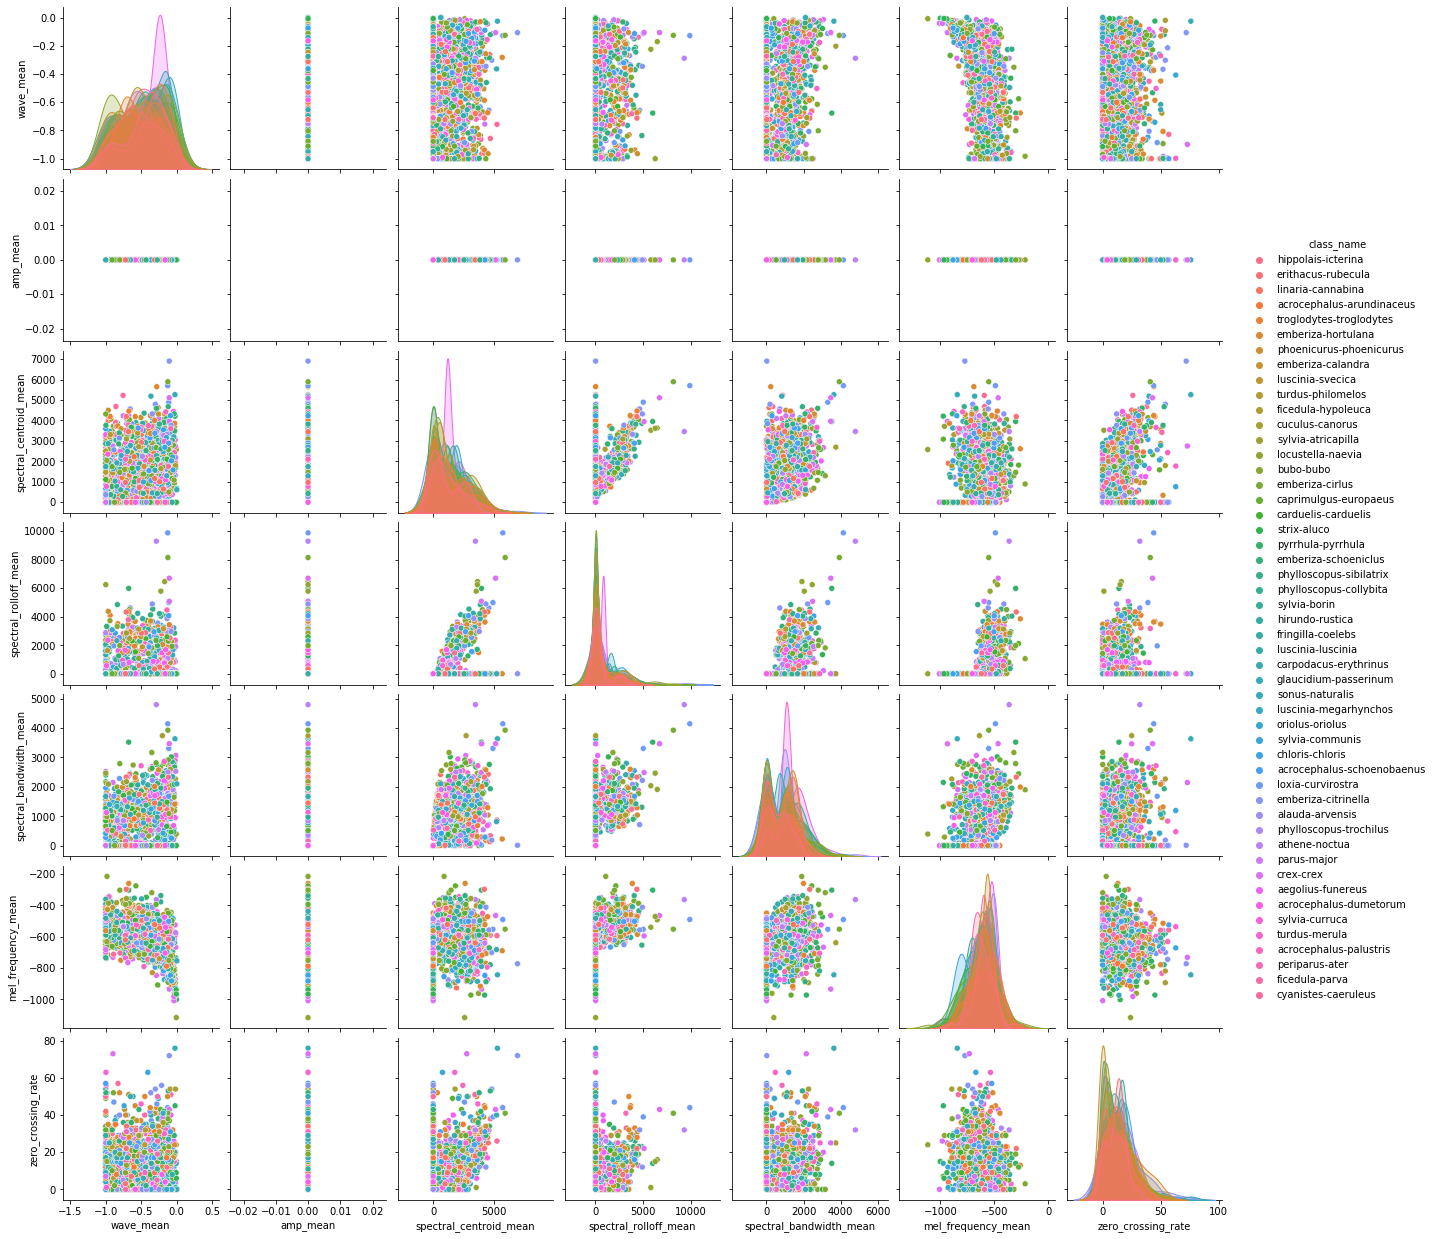

In [65]:
sns_plot = sns.pairplot(data[[
    'class_name',
    'wave_mean', 
    'amp_mean', 
    'spectral_centroid_mean', 
    'spectral_rolloff_mean', 
    'spectral_bandwidth_mean', 
    'mel_frequency_mean', 
    'zero_crossing_rate'
]], hue="class_name")

In [25]:
# data = data[['wave_mean', 
#     'amp_mean', 
#     'spectral_centroid_mean', 
#     'spectral_rolloff_mean', 
#     'spectral_bandwidth_mean', 
#     'mel_frequency_mean', 
#     'zero_crossing_rate']]

In [26]:
encoder = LabelEncoder()
y = encoder.fit_transform(birds_classes)
num_classes = max(y) + 1

In [27]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, 3:]))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [28]:
print(len(X_train))
print(len(X_test))

1719
430


{0: 0.7, 1: 0.62, 2: 0.78, 3: 0.78, 4: 0.74, 5: 0.76, 6: 0.78, 7: 0.64, 8: 0.72, 9: 0.58, 10: 0.7, 11: 0.76, 12: 0.64, 13: 0.66, 14: 0.68, 15: 0.72, 16: 0.56, 17: 0.7, 18: 0.74, 19: 0.68, 20: 0.62, 21: 0.7, 22: 0.8, 23: 0.68, 24: 0.64, 25: 0.64, 26: 0.68, 27: 0.72, 28: 0.7, 29: 0.58, 30: 0.72, 31: 0.66, 32: 0.64, 33: 0.66, 34: 0.68, 35: 0.7, 36: 0.66, 37: 0.66, 38: 0.68, 39: 0.76, 40: 0.64, 41: 0.68, 42: 0.7, 43: 0.64, 44: 0.66, 45: 0.7, 46: 0.68, 47: 0.72, 48: 0.72, 49: 0.72}


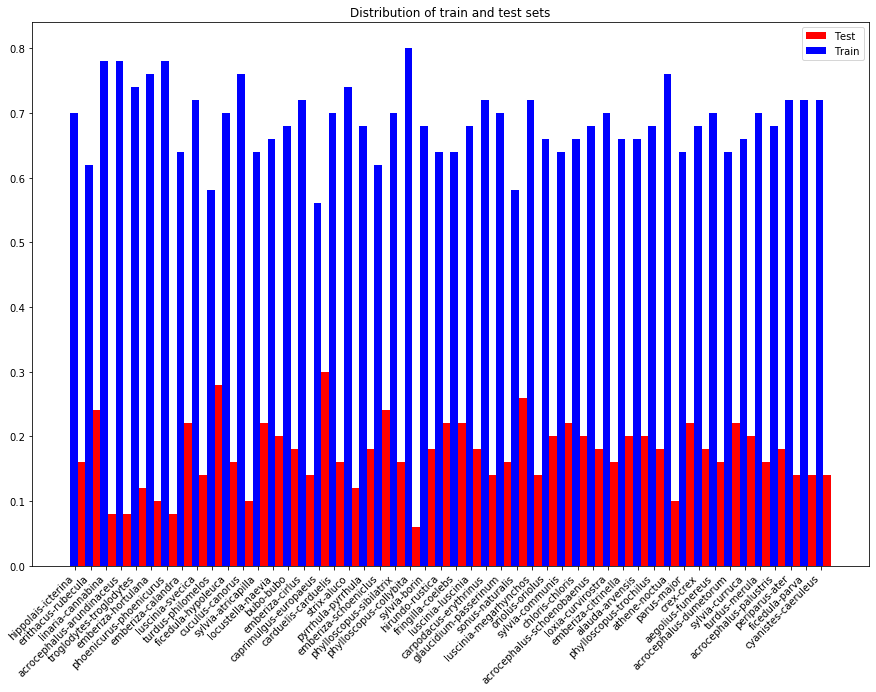

In [29]:
unique_test = np.unique(y_test, return_counts=True)
unique_train = np.unique(y_train, return_counts=True)
unique_classes = np.unique(np.concatenate((unique_test[0], unique_train[0])))

ctt = {}
for x in zip(unique_test[0], unique_test[1]):
    ctt[x[0]] = x[1]/len(unique_classes)
    
ctr = {}
for x in zip(unique_train[0], unique_train[1]):
    ctr[x[0]] = x[1]/len(unique_classes)
    
print(ctr)

width = 0.5
target_names = class_names
ind = np.arange(1, unique_classes.max() + 2)
fig, ax = plt.subplots(figsize=(15, 10))

for i in unique_classes:
    ax.bar(width * 2 + i + 1, 0 if not i in ctt else ctt.get(i), width, color='r')
    ax.bar(width + i + 1, 0 if not i in ctr else ctr.get(i), width, color='b')

ax.set_xticks(ind + width + 0.1)
ax.set_xticklabels(target_names, rotation=45, ha="right")

plt.legend(['Test', 'Train'], loc="best")
plt.title("Distribution of train and test sets");

In [30]:
from keras import optimizers

STEPS_PER_EPOCH = 1

initial_learning_rate = 0.001
decay_steps = 100
decay_rate = 0.1

lr_schedule = optimizers.schedules.InverseTimeDecay(
  initial_learning_rate,
  decay_steps=decay_steps,
  decay_rate=decay_rate
)

def get_optimizer():
    return optimizers.Adam(initial_learning_rate)

In [31]:
def get_callbacks(name):
    return [
        callbacks.EarlyStopping(monitor='loss', patience=3),
        callbacks.TensorBoard("./logs/{}".format(name)),
    ]

def compile_and_fit(model, name, max_epochs=500):
    model.compile(optimizer=get_optimizer(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    
    h = model.fit(X_train,
                  y_train,
                  validation_split = 0.2,
                  callbacks=get_callbacks(name),
                  epochs=max_epochs)
    return h

In [32]:
size_histories = {}

In [33]:
tiny16 = Sequential()
tiny16.add(layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)))
tiny16.add(layers.Dense(num_classes, activation='softmax'))

size_histories['Tiny16'] = compile_and_fit(tiny16, "sizes/Tiny16")

Epoch 1/500
 1/43 [..............................] - ETA: 0s - loss: 3.8676 - accuracy: 0.0625WARNING:tensorflow:From /home/fstovarr/anaconda3/envs/birds/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
43/43 [==============================] - 0s 5ms/step - loss: 3.9726 - accuracy: 0.0233 - val_loss: 3.9835 - val_accuracy: 0.0174
Epoch 2/500
43/43 [==============================] - 0s 2ms/step - loss: 3.9056 - accuracy: 0.0320 - val_loss: 3.9460 - val_accuracy: 0.0145
Epoch 3/500
43/43 [==============================] - 0s 2ms/step - loss: 3.8590 - accuracy: 0.0422 - val_loss: 3.9199 - val_accuracy: 0.0291
Epoch 4/500
43/43 [==============================] - 0s 2ms/step - loss: 3.8192 - accuracy: 0.0582 - val_loss: 3.8980 - val_accuracy: 0.0436
Epoch 5/500
43/43 [==============================] 

Epoch 55/500
43/43 [==============================] - 0s 2ms/step - loss: 2.7829 - accuracy: 0.2633 - val_loss: 3.5015 - val_accuracy: 0.1773
Epoch 56/500
43/43 [==============================] - 0s 2ms/step - loss: 2.7750 - accuracy: 0.2705 - val_loss: 3.5034 - val_accuracy: 0.1831
Epoch 57/500
43/43 [==============================] - 0s 2ms/step - loss: 2.7653 - accuracy: 0.2764 - val_loss: 3.5005 - val_accuracy: 0.1802
Epoch 58/500
43/43 [==============================] - 0s 2ms/step - loss: 2.7575 - accuracy: 0.2720 - val_loss: 3.4969 - val_accuracy: 0.1831
Epoch 59/500
43/43 [==============================] - 0s 2ms/step - loss: 2.7493 - accuracy: 0.2720 - val_loss: 3.4965 - val_accuracy: 0.1831
Epoch 60/500
43/43 [==============================] - 0s 2ms/step - loss: 2.7406 - accuracy: 0.2749 - val_loss: 3.4931 - val_accuracy: 0.1802
Epoch 61/500
43/43 [==============================] - 0s 2ms/step - loss: 2.7329 - accuracy: 0.2778 - val_loss: 3.4892 - val_accuracy: 0.1802
Epoch 

43/43 [==============================] - 0s 2ms/step - loss: 2.3068 - accuracy: 0.3782 - val_loss: 3.5610 - val_accuracy: 0.2093
Epoch 170/500
43/43 [==============================] - 0s 2ms/step - loss: 2.3037 - accuracy: 0.3775 - val_loss: 3.5592 - val_accuracy: 0.2064
Epoch 171/500
43/43 [==============================] - 0s 2ms/step - loss: 2.3018 - accuracy: 0.3833 - val_loss: 3.5616 - val_accuracy: 0.2064
Epoch 172/500
43/43 [==============================] - 0s 2ms/step - loss: 2.3006 - accuracy: 0.3775 - val_loss: 3.5583 - val_accuracy: 0.2151
Epoch 173/500
43/43 [==============================] - 0s 2ms/step - loss: 2.2969 - accuracy: 0.3862 - val_loss: 3.5645 - val_accuracy: 0.2122
Epoch 174/500
43/43 [==============================] - 0s 2ms/step - loss: 2.2967 - accuracy: 0.3855 - val_loss: 3.5669 - val_accuracy: 0.2064
Epoch 175/500
43/43 [==============================] - 0s 2ms/step - loss: 2.2940 - accuracy: 0.3782 - val_loss: 3.5695 - val_accuracy: 0.2122
Epoch 176/500

43/43 [==============================] - 0s 2ms/step - loss: 2.1372 - accuracy: 0.4087 - val_loss: 3.7613 - val_accuracy: 0.2180
Epoch 284/500
43/43 [==============================] - 0s 3ms/step - loss: 2.1354 - accuracy: 0.4116 - val_loss: 3.7688 - val_accuracy: 0.2209
Epoch 285/500
43/43 [==============================] - 0s 3ms/step - loss: 2.1375 - accuracy: 0.4153 - val_loss: 3.7694 - val_accuracy: 0.2151
Epoch 286/500
43/43 [==============================] - 0s 2ms/step - loss: 2.1346 - accuracy: 0.4124 - val_loss: 3.7675 - val_accuracy: 0.2151
Epoch 287/500
43/43 [==============================] - 0s 3ms/step - loss: 2.1333 - accuracy: 0.4116 - val_loss: 3.7706 - val_accuracy: 0.2267
Epoch 288/500
43/43 [==============================] - 0s 2ms/step - loss: 2.1328 - accuracy: 0.4160 - val_loss: 3.7702 - val_accuracy: 0.2238
Epoch 289/500
43/43 [==============================] - 0s 3ms/step - loss: 2.1317 - accuracy: 0.4095 - val_loss: 3.7733 - val_accuracy: 0.2209
Epoch 290/500

43/43 [==============================] - 0s 2ms/step - loss: 2.0387 - accuracy: 0.4429 - val_loss: 3.9530 - val_accuracy: 0.2209
Epoch 398/500
43/43 [==============================] - 0s 2ms/step - loss: 2.0389 - accuracy: 0.4480 - val_loss: 3.9539 - val_accuracy: 0.2209
Epoch 399/500
43/43 [==============================] - 0s 2ms/step - loss: 2.0371 - accuracy: 0.4487 - val_loss: 3.9485 - val_accuracy: 0.2238
Epoch 400/500
43/43 [==============================] - 0s 2ms/step - loss: 2.0373 - accuracy: 0.4465 - val_loss: 3.9588 - val_accuracy: 0.2297
Epoch 401/500
43/43 [==============================] - 0s 1ms/step - loss: 2.0362 - accuracy: 0.4487 - val_loss: 3.9589 - val_accuracy: 0.2180
Epoch 402/500
43/43 [==============================] - 0s 2ms/step - loss: 2.0345 - accuracy: 0.4473 - val_loss: 3.9588 - val_accuracy: 0.2238
Epoch 403/500
43/43 [==============================] - 0s 2ms/step - loss: 2.0344 - accuracy: 0.4495 - val_loss: 3.9621 - val_accuracy: 0.2180
Epoch 404/500

In [34]:
tiny32 = Sequential()
tiny32.add(layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
tiny32.add(layers.Dense(num_classes, activation='softmax'))

size_histories['Tiny32'] = compile_and_fit(tiny32, "sizes/Tiny32")

Epoch 1/500
43/43 [==============================] - 0s 5ms/step - loss: 4.0326 - accuracy: 0.0175 - val_loss: 3.9507 - val_accuracy: 0.0174
Epoch 2/500
43/43 [==============================] - 0s 2ms/step - loss: 3.9108 - accuracy: 0.0262 - val_loss: 3.8895 - val_accuracy: 0.0407
Epoch 3/500
43/43 [==============================] - 0s 2ms/step - loss: 3.8235 - accuracy: 0.0487 - val_loss: 3.8447 - val_accuracy: 0.0465
Epoch 4/500
43/43 [==============================] - 0s 2ms/step - loss: 3.7512 - accuracy: 0.0705 - val_loss: 3.8089 - val_accuracy: 0.0610
Epoch 5/500
43/43 [==============================] - 0s 2ms/step - loss: 3.6822 - accuracy: 0.0895 - val_loss: 3.7763 - val_accuracy: 0.0785
Epoch 6/500
43/43 [==============================] - 0s 2ms/step - loss: 3.6185 - accuracy: 0.1055 - val_loss: 3.7491 - val_accuracy: 0.0843
Epoch 7/500
43/43 [==============================] - 0s 2ms/step - loss: 3.5562 - accuracy: 0.1215 - val_loss: 3.7218 - val_accuracy: 0.0901
Epoch 8/500
4

Epoch 57/500
43/43 [==============================] - 0s 2ms/step - loss: 2.3031 - accuracy: 0.4058 - val_loss: 3.6815 - val_accuracy: 0.1948
Epoch 58/500
43/43 [==============================] - 0s 2ms/step - loss: 2.2908 - accuracy: 0.4022 - val_loss: 3.6830 - val_accuracy: 0.1948
Epoch 59/500
43/43 [==============================] - 0s 2ms/step - loss: 2.2797 - accuracy: 0.4087 - val_loss: 3.6902 - val_accuracy: 0.2006
Epoch 60/500
43/43 [==============================] - 0s 2ms/step - loss: 2.2700 - accuracy: 0.4044 - val_loss: 3.6975 - val_accuracy: 0.2006
Epoch 61/500
43/43 [==============================] - 0s 2ms/step - loss: 2.2593 - accuracy: 0.4138 - val_loss: 3.7038 - val_accuracy: 0.2006
Epoch 62/500
43/43 [==============================] - 0s 2ms/step - loss: 2.2491 - accuracy: 0.4087 - val_loss: 3.7070 - val_accuracy: 0.2064
Epoch 63/500
43/43 [==============================] - 0s 2ms/step - loss: 2.2389 - accuracy: 0.4138 - val_loss: 3.7105 - val_accuracy: 0.1919
Epoch 

43/43 [==============================] - 0s 2ms/step - loss: 1.6437 - accuracy: 0.5527 - val_loss: 4.4533 - val_accuracy: 0.2326
Epoch 172/500
43/43 [==============================] - 0s 2ms/step - loss: 1.6409 - accuracy: 0.5549 - val_loss: 4.4670 - val_accuracy: 0.2355
Epoch 173/500
43/43 [==============================] - 0s 2ms/step - loss: 1.6401 - accuracy: 0.5542 - val_loss: 4.4658 - val_accuracy: 0.2355
Epoch 174/500
43/43 [==============================] - 0s 2ms/step - loss: 1.6348 - accuracy: 0.5520 - val_loss: 4.4767 - val_accuracy: 0.2238
Epoch 175/500
43/43 [==============================] - 0s 2ms/step - loss: 1.6307 - accuracy: 0.5549 - val_loss: 4.4785 - val_accuracy: 0.2297
Epoch 176/500
43/43 [==============================] - 0s 2ms/step - loss: 1.6285 - accuracy: 0.5585 - val_loss: 4.4964 - val_accuracy: 0.2326
Epoch 177/500
43/43 [==============================] - 0s 2ms/step - loss: 1.6268 - accuracy: 0.5505 - val_loss: 4.5051 - val_accuracy: 0.2326
Epoch 178/500

43/43 [==============================] - 0s 2ms/step - loss: 1.3775 - accuracy: 0.6182 - val_loss: 5.4455 - val_accuracy: 0.2267
Epoch 286/500
43/43 [==============================] - 0s 2ms/step - loss: 1.3761 - accuracy: 0.6233 - val_loss: 5.4457 - val_accuracy: 0.2326
Epoch 287/500
43/43 [==============================] - 0s 2ms/step - loss: 1.3755 - accuracy: 0.6138 - val_loss: 5.4604 - val_accuracy: 0.2267
Epoch 288/500
43/43 [==============================] - 0s 2ms/step - loss: 1.3738 - accuracy: 0.6204 - val_loss: 5.4757 - val_accuracy: 0.2297
Epoch 289/500
43/43 [==============================] - 0s 2ms/step - loss: 1.3720 - accuracy: 0.6189 - val_loss: 5.4721 - val_accuracy: 0.2238
Epoch 290/500
43/43 [==============================] - 0s 2ms/step - loss: 1.3708 - accuracy: 0.6196 - val_loss: 5.4905 - val_accuracy: 0.2238
Epoch 291/500
43/43 [==============================] - 0s 2ms/step - loss: 1.3679 - accuracy: 0.6145 - val_loss: 5.5002 - val_accuracy: 0.2267
Epoch 292/500

43/43 [==============================] - 0s 2ms/step - loss: 1.2218 - accuracy: 0.6531 - val_loss: 6.4849 - val_accuracy: 0.2238
Epoch 400/500
43/43 [==============================] - 0s 2ms/step - loss: 1.2201 - accuracy: 0.6545 - val_loss: 6.4944 - val_accuracy: 0.2209
Epoch 401/500
43/43 [==============================] - 0s 2ms/step - loss: 1.2207 - accuracy: 0.6553 - val_loss: 6.5095 - val_accuracy: 0.2267
Epoch 402/500
43/43 [==============================] - 0s 2ms/step - loss: 1.2171 - accuracy: 0.6625 - val_loss: 6.5189 - val_accuracy: 0.2209
Epoch 403/500
43/43 [==============================] - 0s 2ms/step - loss: 1.2173 - accuracy: 0.6575 - val_loss: 6.5223 - val_accuracy: 0.2238
Epoch 404/500
43/43 [==============================] - 0s 2ms/step - loss: 1.2171 - accuracy: 0.6567 - val_loss: 6.5415 - val_accuracy: 0.2151
Epoch 405/500
43/43 [==============================] - 0s 2ms/step - loss: 1.2151 - accuracy: 0.6560 - val_loss: 6.5399 - val_accuracy: 0.2326
Epoch 406/500

In [35]:
small16 = Sequential()
small16.add(layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)))
small16.add(layers.Dense(16, activation='relu'))
small16.add(layers.Dense(num_classes, activation='softmax'))

size_histories['Small16'] = compile_and_fit(small16, "sizes/Small16")

Epoch 1/500
43/43 [==============================] - 0s 5ms/step - loss: 3.9472 - accuracy: 0.0175 - val_loss: 3.9795 - val_accuracy: 0.0116
Epoch 2/500
43/43 [==============================] - 0s 2ms/step - loss: 3.8949 - accuracy: 0.0189 - val_loss: 3.9527 - val_accuracy: 0.0058
Epoch 3/500
43/43 [==============================] - 0s 2ms/step - loss: 3.8614 - accuracy: 0.0342 - val_loss: 3.9389 - val_accuracy: 0.0087
Epoch 4/500
43/43 [==============================] - 0s 2ms/step - loss: 3.8302 - accuracy: 0.0524 - val_loss: 3.9314 - val_accuracy: 0.0407
Epoch 5/500
43/43 [==============================] - 0s 2ms/step - loss: 3.7953 - accuracy: 0.0720 - val_loss: 3.9228 - val_accuracy: 0.0436
Epoch 6/500
43/43 [==============================] - 0s 2ms/step - loss: 3.7560 - accuracy: 0.0873 - val_loss: 3.9134 - val_accuracy: 0.0581
Epoch 7/500
43/43 [==============================] - 0s 2ms/step - loss: 3.7111 - accuracy: 0.1011 - val_loss: 3.9007 - val_accuracy: 0.0552
Epoch 8/500
4

Epoch 57/500
43/43 [==============================] - 0s 2ms/step - loss: 2.5900 - accuracy: 0.3142 - val_loss: 3.5827 - val_accuracy: 0.2006
Epoch 58/500
43/43 [==============================] - 0s 2ms/step - loss: 2.5810 - accuracy: 0.3091 - val_loss: 3.5993 - val_accuracy: 0.1919
Epoch 59/500
43/43 [==============================] - 0s 2ms/step - loss: 2.5733 - accuracy: 0.3164 - val_loss: 3.6000 - val_accuracy: 0.1860
Epoch 60/500
43/43 [==============================] - 0s 2ms/step - loss: 2.5627 - accuracy: 0.3069 - val_loss: 3.5901 - val_accuracy: 0.1977
Epoch 61/500
43/43 [==============================] - 0s 2ms/step - loss: 2.5521 - accuracy: 0.3135 - val_loss: 3.5946 - val_accuracy: 0.1977
Epoch 62/500
43/43 [==============================] - 0s 2ms/step - loss: 2.5444 - accuracy: 0.3149 - val_loss: 3.6017 - val_accuracy: 0.1977
Epoch 63/500
43/43 [==============================] - 0s 2ms/step - loss: 2.5347 - accuracy: 0.3244 - val_loss: 3.6007 - val_accuracy: 0.1919
Epoch 

43/43 [==============================] - 0s 2ms/step - loss: 2.0654 - accuracy: 0.4364 - val_loss: 4.1881 - val_accuracy: 0.2297
Epoch 172/500
43/43 [==============================] - 0s 2ms/step - loss: 2.0645 - accuracy: 0.4458 - val_loss: 4.1879 - val_accuracy: 0.2326
Epoch 173/500
43/43 [==============================] - 0s 2ms/step - loss: 2.0592 - accuracy: 0.4422 - val_loss: 4.2044 - val_accuracy: 0.2238
Epoch 174/500
43/43 [==============================] - 0s 2ms/step - loss: 2.0593 - accuracy: 0.4342 - val_loss: 4.2136 - val_accuracy: 0.2384
Epoch 175/500
43/43 [==============================] - 0s 2ms/step - loss: 2.0545 - accuracy: 0.4393 - val_loss: 4.2230 - val_accuracy: 0.2355
Epoch 176/500
43/43 [==============================] - 0s 2ms/step - loss: 2.0528 - accuracy: 0.4415 - val_loss: 4.2126 - val_accuracy: 0.2413
Epoch 177/500
43/43 [==============================] - 0s 2ms/step - loss: 2.0519 - accuracy: 0.4422 - val_loss: 4.2201 - val_accuracy: 0.2384
Epoch 178/500

In [36]:
small32 = Sequential()
small32.add(layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
small32.add(layers.Dense(32, activation='relu'))
small32.add(layers.Dense(num_classes, activation='softmax'))

size_histories['Small32'] = compile_and_fit(small32, "sizes/Small32")

Epoch 1/500
43/43 [==============================] - 0s 5ms/step - loss: 3.9408 - accuracy: 0.0204 - val_loss: 3.9316 - val_accuracy: 0.0233
Epoch 2/500
43/43 [==============================] - 0s 2ms/step - loss: 3.8509 - accuracy: 0.0509 - val_loss: 3.8905 - val_accuracy: 0.0785
Epoch 3/500
43/43 [==============================] - 0s 2ms/step - loss: 3.7826 - accuracy: 0.0880 - val_loss: 3.8535 - val_accuracy: 0.0843
Epoch 4/500
43/43 [==============================] - 0s 2ms/step - loss: 3.7075 - accuracy: 0.1171 - val_loss: 3.8097 - val_accuracy: 0.0756
Epoch 5/500
43/43 [==============================] - 0s 2ms/step - loss: 3.6170 - accuracy: 0.1338 - val_loss: 3.7555 - val_accuracy: 0.0814
Epoch 6/500
43/43 [==============================] - 0s 2ms/step - loss: 3.5173 - accuracy: 0.1484 - val_loss: 3.7086 - val_accuracy: 0.0814
Epoch 7/500
43/43 [==============================] - 0s 2ms/step - loss: 3.4164 - accuracy: 0.1658 - val_loss: 3.6605 - val_accuracy: 0.1047
Epoch 8/500
4

Epoch 57/500
43/43 [==============================] - 0s 2ms/step - loss: 1.9343 - accuracy: 0.4691 - val_loss: 3.8483 - val_accuracy: 0.2122
Epoch 58/500
43/43 [==============================] - 0s 2ms/step - loss: 1.9184 - accuracy: 0.4749 - val_loss: 3.8665 - val_accuracy: 0.2064
Epoch 59/500
43/43 [==============================] - 0s 2ms/step - loss: 1.9070 - accuracy: 0.4858 - val_loss: 3.8643 - val_accuracy: 0.2064
Epoch 60/500
43/43 [==============================] - 0s 2ms/step - loss: 1.8927 - accuracy: 0.4764 - val_loss: 3.8729 - val_accuracy: 0.2035
Epoch 61/500
43/43 [==============================] - 0s 2ms/step - loss: 1.8798 - accuracy: 0.4865 - val_loss: 3.8834 - val_accuracy: 0.2064
Epoch 62/500
43/43 [==============================] - 0s 2ms/step - loss: 1.8683 - accuracy: 0.4793 - val_loss: 3.8999 - val_accuracy: 0.2035
Epoch 63/500
43/43 [==============================] - 0s 2ms/step - loss: 1.8512 - accuracy: 0.5011 - val_loss: 3.9216 - val_accuracy: 0.2093
Epoch 

43/43 [==============================] - 0s 2ms/step - loss: 1.1001 - accuracy: 0.6945 - val_loss: 5.5934 - val_accuracy: 0.2064
Epoch 172/500
43/43 [==============================] - 0s 2ms/step - loss: 1.0956 - accuracy: 0.7011 - val_loss: 5.5810 - val_accuracy: 0.2035
Epoch 173/500
43/43 [==============================] - 0s 2ms/step - loss: 1.0865 - accuracy: 0.7018 - val_loss: 5.6245 - val_accuracy: 0.2093
Epoch 174/500
43/43 [==============================] - 0s 2ms/step - loss: 1.0829 - accuracy: 0.7004 - val_loss: 5.6396 - val_accuracy: 0.2093
Epoch 175/500
43/43 [==============================] - 0s 2ms/step - loss: 1.0802 - accuracy: 0.7069 - val_loss: 5.6503 - val_accuracy: 0.2122
Epoch 176/500
43/43 [==============================] - 0s 2ms/step - loss: 1.0784 - accuracy: 0.7156 - val_loss: 5.6647 - val_accuracy: 0.2006
Epoch 177/500
43/43 [==============================] - 0s 2ms/step - loss: 1.0796 - accuracy: 0.7040 - val_loss: 5.6965 - val_accuracy: 0.1919
Epoch 178/500

43/43 [==============================] - 0s 2ms/step - loss: 0.7143 - accuracy: 0.7978 - val_loss: 7.7261 - val_accuracy: 0.1977
Epoch 286/500
43/43 [==============================] - 0s 2ms/step - loss: 0.7105 - accuracy: 0.8116 - val_loss: 7.7543 - val_accuracy: 0.2006
Epoch 287/500
43/43 [==============================] - 0s 2ms/step - loss: 0.7042 - accuracy: 0.8087 - val_loss: 7.7813 - val_accuracy: 0.2064
Epoch 288/500
43/43 [==============================] - 0s 2ms/step - loss: 0.7035 - accuracy: 0.8138 - val_loss: 7.7904 - val_accuracy: 0.2006
Epoch 289/500
43/43 [==============================] - 0s 2ms/step - loss: 0.7040 - accuracy: 0.8051 - val_loss: 7.7943 - val_accuracy: 0.2035
Epoch 290/500
43/43 [==============================] - 0s 2ms/step - loss: 0.7014 - accuracy: 0.8116 - val_loss: 7.8737 - val_accuracy: 0.2035
Epoch 291/500
43/43 [==============================] - 0s 2ms/step - loss: 0.6964 - accuracy: 0.8167 - val_loss: 7.8796 - val_accuracy: 0.1977
Epoch 292/500

43/43 [==============================] - 0s 2ms/step - loss: 0.4395 - accuracy: 0.9062 - val_loss: 10.6008 - val_accuracy: 0.2209
Epoch 400/500
43/43 [==============================] - 0s 2ms/step - loss: 0.4412 - accuracy: 0.9047 - val_loss: 10.6280 - val_accuracy: 0.2122
Epoch 401/500
43/43 [==============================] - 0s 2ms/step - loss: 0.4334 - accuracy: 0.9040 - val_loss: 10.6459 - val_accuracy: 0.2180
Epoch 402/500
43/43 [==============================] - 0s 2ms/step - loss: 0.4345 - accuracy: 0.9076 - val_loss: 10.7413 - val_accuracy: 0.2180
Epoch 403/500
43/43 [==============================] - 0s 2ms/step - loss: 0.4326 - accuracy: 0.9011 - val_loss: 10.7167 - val_accuracy: 0.2238
Epoch 404/500
43/43 [==============================] - 0s 2ms/step - loss: 0.4285 - accuracy: 0.9033 - val_loss: 10.7771 - val_accuracy: 0.2122
Epoch 405/500
43/43 [==============================] - 0s 2ms/step - loss: 0.4280 - accuracy: 0.9055 - val_loss: 10.7871 - val_accuracy: 0.2180
Epoch 

In [37]:
medium16 = Sequential()
medium16.add(layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)))
medium16.add(layers.Dense(16, activation='relu'))
medium16.add(layers.Dense(16, activation='relu'))
medium16.add(layers.Dense(num_classes, activation='softmax'))

size_histories['Medium16'] = compile_and_fit(medium16, "sizes/Medium16")

Epoch 1/500
43/43 [==============================] - 0s 6ms/step - loss: 3.9218 - accuracy: 0.0167 - val_loss: 3.9169 - val_accuracy: 0.0174
Epoch 2/500
43/43 [==============================] - 0s 2ms/step - loss: 3.9009 - accuracy: 0.0225 - val_loss: 3.9086 - val_accuracy: 0.0262
Epoch 3/500
43/43 [==============================] - 0s 2ms/step - loss: 3.8829 - accuracy: 0.0465 - val_loss: 3.8995 - val_accuracy: 0.0320
Epoch 4/500
43/43 [==============================] - 0s 2ms/step - loss: 3.8583 - accuracy: 0.0625 - val_loss: 3.8792 - val_accuracy: 0.0523
Epoch 5/500
43/43 [==============================] - 0s 2ms/step - loss: 3.8187 - accuracy: 0.0800 - val_loss: 3.8555 - val_accuracy: 0.0727
Epoch 6/500
43/43 [==============================] - 0s 2ms/step - loss: 3.7648 - accuracy: 0.0873 - val_loss: 3.8248 - val_accuracy: 0.0872
Epoch 7/500
43/43 [==============================] - 0s 2ms/step - loss: 3.6975 - accuracy: 0.1047 - val_loss: 3.7923 - val_accuracy: 0.0901
Epoch 8/500
4

Epoch 57/500
43/43 [==============================] - 0s 2ms/step - loss: 2.5754 - accuracy: 0.3178 - val_loss: 4.0891 - val_accuracy: 0.1512
Epoch 58/500
43/43 [==============================] - 0s 2ms/step - loss: 2.5656 - accuracy: 0.3200 - val_loss: 4.0824 - val_accuracy: 0.1599
Epoch 59/500
43/43 [==============================] - 0s 2ms/step - loss: 2.5589 - accuracy: 0.3229 - val_loss: 4.1015 - val_accuracy: 0.1453
Epoch 60/500
43/43 [==============================] - 0s 2ms/step - loss: 2.5483 - accuracy: 0.3251 - val_loss: 4.1321 - val_accuracy: 0.1541
Epoch 61/500
43/43 [==============================] - 0s 2ms/step - loss: 2.5356 - accuracy: 0.3302 - val_loss: 4.1302 - val_accuracy: 0.1483
Epoch 62/500
43/43 [==============================] - 0s 2ms/step - loss: 2.5282 - accuracy: 0.3149 - val_loss: 4.1301 - val_accuracy: 0.1686
Epoch 63/500
43/43 [==============================] - 0s 2ms/step - loss: 2.5226 - accuracy: 0.3273 - val_loss: 4.1618 - val_accuracy: 0.1512
Epoch 

43/43 [==============================] - 0s 2ms/step - loss: 2.0112 - accuracy: 0.4400 - val_loss: 5.3828 - val_accuracy: 0.2035
Epoch 172/500
43/43 [==============================] - 0s 2ms/step - loss: 2.0090 - accuracy: 0.4465 - val_loss: 5.3558 - val_accuracy: 0.1977
Epoch 173/500
43/43 [==============================] - 0s 2ms/step - loss: 2.0071 - accuracy: 0.4415 - val_loss: 5.3932 - val_accuracy: 0.2064
Epoch 174/500
43/43 [==============================] - 0s 2ms/step - loss: 2.0018 - accuracy: 0.4495 - val_loss: 5.4172 - val_accuracy: 0.2006
Epoch 175/500
43/43 [==============================] - 0s 2ms/step - loss: 2.0002 - accuracy: 0.4371 - val_loss: 5.4325 - val_accuracy: 0.1948
Epoch 176/500
43/43 [==============================] - 0s 2ms/step - loss: 2.0000 - accuracy: 0.4444 - val_loss: 5.4388 - val_accuracy: 0.2035
Epoch 177/500
43/43 [==============================] - 0s 2ms/step - loss: 1.9954 - accuracy: 0.4400 - val_loss: 5.4332 - val_accuracy: 0.1977
Epoch 178/500

In [38]:
medium32 = Sequential()
medium32.add(layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
medium32.add(layers.Dense(32, activation='relu'))
medium32.add(layers.Dense(32, activation='relu'))
medium32.add(layers.Dense(num_classes, activation='softmax'))

size_histories['Medium32'] = compile_and_fit(medium32, "sizes/Medium32")

Epoch 1/500
43/43 [==============================] - 0s 6ms/step - loss: 3.9252 - accuracy: 0.0262 - val_loss: 3.8905 - val_accuracy: 0.0407
Epoch 2/500
43/43 [==============================] - 0s 2ms/step - loss: 3.8705 - accuracy: 0.0516 - val_loss: 3.8657 - val_accuracy: 0.0610
Epoch 3/500
43/43 [==============================] - 0s 2ms/step - loss: 3.8142 - accuracy: 0.0662 - val_loss: 3.8370 - val_accuracy: 0.0785
Epoch 4/500
43/43 [==============================] - 0s 2ms/step - loss: 3.7305 - accuracy: 0.0865 - val_loss: 3.7953 - val_accuracy: 0.0930
Epoch 5/500
43/43 [==============================] - 0s 2ms/step - loss: 3.6311 - accuracy: 0.1040 - val_loss: 3.7599 - val_accuracy: 0.1134
Epoch 6/500
43/43 [==============================] - 0s 2ms/step - loss: 3.5311 - accuracy: 0.1164 - val_loss: 3.7117 - val_accuracy: 0.1308
Epoch 7/500
43/43 [==============================] - 0s 2ms/step - loss: 3.4311 - accuracy: 0.1389 - val_loss: 3.6760 - val_accuracy: 0.1221
Epoch 8/500
4

Epoch 57/500
43/43 [==============================] - 0s 2ms/step - loss: 1.7694 - accuracy: 0.5069 - val_loss: 4.1094 - val_accuracy: 0.2442
Epoch 58/500
43/43 [==============================] - 0s 2ms/step - loss: 1.7544 - accuracy: 0.5098 - val_loss: 4.0848 - val_accuracy: 0.2558
Epoch 59/500
43/43 [==============================] - 0s 2ms/step - loss: 1.7392 - accuracy: 0.5084 - val_loss: 4.1242 - val_accuracy: 0.2326
Epoch 60/500
43/43 [==============================] - 0s 2ms/step - loss: 1.7184 - accuracy: 0.5287 - val_loss: 4.1907 - val_accuracy: 0.2297
Epoch 61/500
43/43 [==============================] - 0s 2ms/step - loss: 1.7102 - accuracy: 0.5265 - val_loss: 4.1751 - val_accuracy: 0.2384
Epoch 62/500
43/43 [==============================] - 0s 2ms/step - loss: 1.6937 - accuracy: 0.5316 - val_loss: 4.2350 - val_accuracy: 0.2442
Epoch 63/500
43/43 [==============================] - 0s 2ms/step - loss: 1.6771 - accuracy: 0.5273 - val_loss: 4.2844 - val_accuracy: 0.2326
Epoch 

43/43 [==============================] - 0s 2ms/step - loss: 0.6972 - accuracy: 0.8175 - val_loss: 7.8254 - val_accuracy: 0.2238
Epoch 172/500
43/43 [==============================] - 0s 2ms/step - loss: 0.6954 - accuracy: 0.8131 - val_loss: 7.8109 - val_accuracy: 0.2267
Epoch 173/500
43/43 [==============================] - 0s 2ms/step - loss: 0.6866 - accuracy: 0.8109 - val_loss: 7.9502 - val_accuracy: 0.2297
Epoch 174/500
43/43 [==============================] - 0s 2ms/step - loss: 0.6808 - accuracy: 0.8247 - val_loss: 8.0035 - val_accuracy: 0.2180
Epoch 175/500
43/43 [==============================] - 0s 2ms/step - loss: 0.6735 - accuracy: 0.8342 - val_loss: 7.9549 - val_accuracy: 0.2267
Epoch 176/500
43/43 [==============================] - 0s 2ms/step - loss: 0.6662 - accuracy: 0.8298 - val_loss: 8.0502 - val_accuracy: 0.2267
Epoch 177/500
43/43 [==============================] - 0s 2ms/step - loss: 0.6669 - accuracy: 0.8284 - val_loss: 8.0277 - val_accuracy: 0.2267
Epoch 178/500

In [39]:
mediumIncreasing8 = Sequential()
mediumIncreasing8.add(layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)))
mediumIncreasing8.add(layers.Dense(32, activation='relu'))
mediumIncreasing8.add(layers.Dense(40, activation='relu'))
mediumIncreasing8.add(layers.Dense(num_classes, activation='softmax'))

size_histories['MediumIncreasing8'] = compile_and_fit(mediumIncreasing8, "sizes/MediumIncreasing8")

Epoch 1/500
43/43 [==============================] - 0s 6ms/step - loss: 3.9455 - accuracy: 0.0182 - val_loss: 3.9303 - val_accuracy: 0.0233
Epoch 2/500
43/43 [==============================] - 0s 2ms/step - loss: 3.8742 - accuracy: 0.0495 - val_loss: 3.9010 - val_accuracy: 0.0203
Epoch 3/500
43/43 [==============================] - 0s 2ms/step - loss: 3.8280 - accuracy: 0.0633 - val_loss: 3.8793 - val_accuracy: 0.0436
Epoch 4/500
43/43 [==============================] - 0s 2ms/step - loss: 3.7732 - accuracy: 0.0749 - val_loss: 3.8560 - val_accuracy: 0.0552
Epoch 5/500
43/43 [==============================] - 0s 2ms/step - loss: 3.7079 - accuracy: 0.0938 - val_loss: 3.8265 - val_accuracy: 0.0785
Epoch 6/500
43/43 [==============================] - 0s 2ms/step - loss: 3.6352 - accuracy: 0.1098 - val_loss: 3.7924 - val_accuracy: 0.0727
Epoch 7/500
43/43 [==============================] - 0s 2ms/step - loss: 3.5491 - accuracy: 0.1229 - val_loss: 3.7641 - val_accuracy: 0.0959
Epoch 8/500
4

Epoch 57/500
43/43 [==============================] - 0s 2ms/step - loss: 2.1401 - accuracy: 0.4044 - val_loss: 3.8852 - val_accuracy: 0.2093
Epoch 58/500
43/43 [==============================] - 0s 2ms/step - loss: 2.1276 - accuracy: 0.4131 - val_loss: 3.8866 - val_accuracy: 0.1977
Epoch 59/500
43/43 [==============================] - 0s 2ms/step - loss: 2.1149 - accuracy: 0.4080 - val_loss: 3.9071 - val_accuracy: 0.2006
Epoch 60/500
43/43 [==============================] - 0s 2ms/step - loss: 2.0988 - accuracy: 0.4153 - val_loss: 3.8948 - val_accuracy: 0.2035
Epoch 61/500
43/43 [==============================] - 0s 2ms/step - loss: 2.0850 - accuracy: 0.4218 - val_loss: 3.9015 - val_accuracy: 0.2006
Epoch 62/500
43/43 [==============================] - 0s 2ms/step - loss: 2.0706 - accuracy: 0.4255 - val_loss: 3.9190 - val_accuracy: 0.2006
Epoch 63/500
43/43 [==============================] - 0s 2ms/step - loss: 2.0627 - accuracy: 0.4291 - val_loss: 3.9255 - val_accuracy: 0.2151
Epoch 

43/43 [==============================] - 0s 3ms/step - loss: 1.1681 - accuracy: 0.6647 - val_loss: 5.4727 - val_accuracy: 0.2238
Epoch 172/500
43/43 [==============================] - 0s 3ms/step - loss: 1.1493 - accuracy: 0.6705 - val_loss: 5.4792 - val_accuracy: 0.2093
Epoch 173/500
43/43 [==============================] - 0s 3ms/step - loss: 1.1539 - accuracy: 0.6618 - val_loss: 5.4822 - val_accuracy: 0.2151
Epoch 174/500
43/43 [==============================] - 0s 3ms/step - loss: 1.1453 - accuracy: 0.6698 - val_loss: 5.5030 - val_accuracy: 0.2180
Epoch 175/500
43/43 [==============================] - 0s 3ms/step - loss: 1.1487 - accuracy: 0.6684 - val_loss: 5.5105 - val_accuracy: 0.2238
Epoch 176/500
43/43 [==============================] - 0s 3ms/step - loss: 1.1356 - accuracy: 0.6655 - val_loss: 5.5679 - val_accuracy: 0.2297
Epoch 177/500
43/43 [==============================] - 0s 2ms/step - loss: 1.1293 - accuracy: 0.6771 - val_loss: 5.5788 - val_accuracy: 0.2122
Epoch 178/500

In [40]:
mediumDecreasing8 = Sequential()
mediumDecreasing8.add(layers.Dense(40, activation='relu', input_shape=(X_train.shape[1],)))
mediumDecreasing8.add(layers.Dense(32, activation='relu'))
mediumDecreasing8.add(layers.Dense(16, activation='relu'))
mediumDecreasing8.add(layers.Dense(num_classes, activation='softmax'))

size_histories['MediumDecreasing8'] = compile_and_fit(mediumDecreasing8, "sizes/MediumDecreasing8")

Epoch 1/500
43/43 [==============================] - 0s 6ms/step - loss: 3.9102 - accuracy: 0.0211 - val_loss: 3.9150 - val_accuracy: 0.0262
Epoch 2/500
43/43 [==============================] - 0s 2ms/step - loss: 3.8729 - accuracy: 0.0327 - val_loss: 3.9050 - val_accuracy: 0.0320
Epoch 3/500
43/43 [==============================] - 0s 2ms/step - loss: 3.8348 - accuracy: 0.0371 - val_loss: 3.8886 - val_accuracy: 0.0581
Epoch 4/500
43/43 [==============================] - 0s 2ms/step - loss: 3.7790 - accuracy: 0.0691 - val_loss: 3.8490 - val_accuracy: 0.0727
Epoch 5/500
43/43 [==============================] - 0s 2ms/step - loss: 3.6985 - accuracy: 0.1069 - val_loss: 3.7902 - val_accuracy: 0.0872
Epoch 6/500
43/43 [==============================] - 0s 2ms/step - loss: 3.5979 - accuracy: 0.1164 - val_loss: 3.7392 - val_accuracy: 0.0959
Epoch 7/500
43/43 [==============================] - 0s 2ms/step - loss: 3.4978 - accuracy: 0.1302 - val_loss: 3.6721 - val_accuracy: 0.1047
Epoch 8/500
4

Epoch 57/500
43/43 [==============================] - 0s 2ms/step - loss: 1.9547 - accuracy: 0.4509 - val_loss: 3.7329 - val_accuracy: 0.2471
Epoch 58/500
43/43 [==============================] - 0s 2ms/step - loss: 1.9387 - accuracy: 0.4589 - val_loss: 3.7523 - val_accuracy: 0.2267
Epoch 59/500
43/43 [==============================] - 0s 2ms/step - loss: 1.9273 - accuracy: 0.4589 - val_loss: 3.7635 - val_accuracy: 0.2267
Epoch 60/500
43/43 [==============================] - 0s 2ms/step - loss: 1.9183 - accuracy: 0.4647 - val_loss: 3.7867 - val_accuracy: 0.2238
Epoch 61/500
43/43 [==============================] - 0s 2ms/step - loss: 1.9023 - accuracy: 0.4676 - val_loss: 3.8153 - val_accuracy: 0.2297
Epoch 62/500
43/43 [==============================] - 0s 2ms/step - loss: 1.8943 - accuracy: 0.4705 - val_loss: 3.8120 - val_accuracy: 0.2326
Epoch 63/500
43/43 [==============================] - 0s 2ms/step - loss: 1.8799 - accuracy: 0.4756 - val_loss: 3.8556 - val_accuracy: 0.2180
Epoch 

43/43 [==============================] - 0s 2ms/step - loss: 1.0432 - accuracy: 0.6975 - val_loss: 6.1002 - val_accuracy: 0.2442
Epoch 172/500
43/43 [==============================] - 0s 2ms/step - loss: 1.0245 - accuracy: 0.7062 - val_loss: 6.1457 - val_accuracy: 0.2413
Epoch 173/500
43/43 [==============================] - 0s 2ms/step - loss: 1.0321 - accuracy: 0.7011 - val_loss: 6.1531 - val_accuracy: 0.2413
Epoch 174/500
43/43 [==============================] - 0s 2ms/step - loss: 1.0187 - accuracy: 0.7105 - val_loss: 6.1156 - val_accuracy: 0.2442
Epoch 175/500
43/43 [==============================] - 0s 2ms/step - loss: 1.0192 - accuracy: 0.7142 - val_loss: 6.2103 - val_accuracy: 0.2413
Epoch 176/500
43/43 [==============================] - 0s 2ms/step - loss: 1.0179 - accuracy: 0.6982 - val_loss: 6.2110 - val_accuracy: 0.2529
Epoch 177/500
43/43 [==============================] - 0s 2ms/step - loss: 1.0043 - accuracy: 0.7193 - val_loss: 6.2023 - val_accuracy: 0.2297
Epoch 178/500

In [41]:
mediumDecreasing2 = Sequential()
mediumDecreasing2.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
mediumDecreasing2.add(layers.Dense(32, activation='relu'))
mediumDecreasing2.add(layers.Dense(16, activation='relu'))
mediumDecreasing2.add(layers.Dense(num_classes, activation='softmax'))

size_histories['MediumDecreasing2'] = compile_and_fit(mediumDecreasing2, "sizes/MediumDecreasing2")

Epoch 1/500
43/43 [==============================] - 0s 6ms/step - loss: 3.9154 - accuracy: 0.0262 - val_loss: 3.9035 - val_accuracy: 0.0436
Epoch 2/500
43/43 [==============================] - 0s 2ms/step - loss: 3.8574 - accuracy: 0.0560 - val_loss: 3.8866 - val_accuracy: 0.0640
Epoch 3/500
43/43 [==============================] - 0s 2ms/step - loss: 3.8076 - accuracy: 0.0727 - val_loss: 3.8661 - val_accuracy: 0.0727
Epoch 4/500
43/43 [==============================] - 0s 2ms/step - loss: 3.7471 - accuracy: 0.0895 - val_loss: 3.8502 - val_accuracy: 0.0727
Epoch 5/500
43/43 [==============================] - 0s 2ms/step - loss: 3.6782 - accuracy: 0.1091 - val_loss: 3.8231 - val_accuracy: 0.0901
Epoch 6/500
43/43 [==============================] - 0s 2ms/step - loss: 3.6012 - accuracy: 0.1244 - val_loss: 3.7814 - val_accuracy: 0.0988
Epoch 7/500
43/43 [==============================] - 0s 2ms/step - loss: 3.5171 - accuracy: 0.1491 - val_loss: 3.7437 - val_accuracy: 0.0988
Epoch 8/500
4

Epoch 57/500
43/43 [==============================] - 0s 2ms/step - loss: 1.7816 - accuracy: 0.5091 - val_loss: 3.8999 - val_accuracy: 0.2558
Epoch 58/500
43/43 [==============================] - 0s 2ms/step - loss: 1.7631 - accuracy: 0.5207 - val_loss: 3.9363 - val_accuracy: 0.2529
Epoch 59/500
43/43 [==============================] - 0s 2ms/step - loss: 1.7493 - accuracy: 0.5171 - val_loss: 3.9721 - val_accuracy: 0.2674
Epoch 60/500
43/43 [==============================] - 0s 2ms/step - loss: 1.7287 - accuracy: 0.5251 - val_loss: 3.9833 - val_accuracy: 0.2674
Epoch 61/500
43/43 [==============================] - 0s 2ms/step - loss: 1.7030 - accuracy: 0.5309 - val_loss: 4.0172 - val_accuracy: 0.2587
Epoch 62/500
43/43 [==============================] - 0s 2ms/step - loss: 1.7071 - accuracy: 0.5404 - val_loss: 4.0089 - val_accuracy: 0.2558
Epoch 63/500
43/43 [==============================] - 0s 2ms/step - loss: 1.6894 - accuracy: 0.5455 - val_loss: 4.0528 - val_accuracy: 0.2645
Epoch 

43/43 [==============================] - 0s 2ms/step - loss: 0.6502 - accuracy: 0.8327 - val_loss: 7.3879 - val_accuracy: 0.2645
Epoch 172/500
43/43 [==============================] - 0s 2ms/step - loss: 0.6515 - accuracy: 0.8349 - val_loss: 7.4895 - val_accuracy: 0.2703
Epoch 173/500
43/43 [==============================] - 0s 2ms/step - loss: 0.6499 - accuracy: 0.8327 - val_loss: 7.5365 - val_accuracy: 0.2674


In [42]:
large512 = Sequential()
large512.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
large512.add(layers.Dense(512, activation='relu'))
large512.add(layers.Dense(512, activation='relu'))
large512.add(layers.Dense(512, activation='relu'))
large512.add(layers.Dense(num_classes, activation='softmax'))

size_histories['Large512'] = compile_and_fit(large512, "sizes/Large512")

Epoch 1/500
43/43 [==============================] - 0s 10ms/step - loss: 3.7999 - accuracy: 0.0742 - val_loss: 3.6959 - val_accuracy: 0.0959
Epoch 2/500
43/43 [==============================] - 0s 7ms/step - loss: 3.2964 - accuracy: 0.1622 - val_loss: 3.5005 - val_accuracy: 0.1453
Epoch 3/500
43/43 [==============================] - 0s 7ms/step - loss: 2.8912 - accuracy: 0.2436 - val_loss: 3.3380 - val_accuracy: 0.1977
Epoch 4/500
43/43 [==============================] - 0s 6ms/step - loss: 2.5362 - accuracy: 0.3156 - val_loss: 3.4209 - val_accuracy: 0.2151
Epoch 5/500
43/43 [==============================] - 0s 7ms/step - loss: 2.1903 - accuracy: 0.3949 - val_loss: 3.4192 - val_accuracy: 0.2267
Epoch 6/500
43/43 [==============================] - 0s 6ms/step - loss: 1.9230 - accuracy: 0.4509 - val_loss: 3.4525 - val_accuracy: 0.2558
Epoch 7/500
43/43 [==============================] - 0s 6ms/step - loss: 1.6553 - accuracy: 0.5105 - val_loss: 3.4866 - val_accuracy: 0.2587
Epoch 8/500


Epoch 112/500
43/43 [==============================] - 0s 6ms/step - loss: 5.3898e-05 - accuracy: 1.0000 - val_loss: 11.7803 - val_accuracy: 0.2994
Epoch 113/500
43/43 [==============================] - 0s 6ms/step - loss: 5.2492e-05 - accuracy: 1.0000 - val_loss: 11.8201 - val_accuracy: 0.2994
Epoch 114/500
43/43 [==============================] - 0s 6ms/step - loss: 5.0898e-05 - accuracy: 1.0000 - val_loss: 11.8432 - val_accuracy: 0.2965
Epoch 115/500
43/43 [==============================] - 0s 7ms/step - loss: 4.9574e-05 - accuracy: 1.0000 - val_loss: 11.8740 - val_accuracy: 0.2965
Epoch 116/500
43/43 [==============================] - 0s 6ms/step - loss: 4.8512e-05 - accuracy: 1.0000 - val_loss: 11.8725 - val_accuracy: 0.2994
Epoch 117/500
43/43 [==============================] - 0s 7ms/step - loss: 4.6951e-05 - accuracy: 1.0000 - val_loss: 11.9120 - val_accuracy: 0.2965
Epoch 118/500
43/43 [==============================] - 0s 6ms/step - loss: 4.5910e-05 - accuracy: 1.0000 - val_l

43/43 [==============================] - 0s 7ms/step - loss: 3.7011e-06 - accuracy: 1.0000 - val_loss: 14.1247 - val_accuracy: 0.2994
Epoch 223/500
43/43 [==============================] - 0s 6ms/step - loss: 3.6109e-06 - accuracy: 1.0000 - val_loss: 14.1396 - val_accuracy: 0.2965
Epoch 224/500
43/43 [==============================] - 0s 6ms/step - loss: 3.5364e-06 - accuracy: 1.0000 - val_loss: 14.1664 - val_accuracy: 0.2965
Epoch 225/500
43/43 [==============================] - 0s 8ms/step - loss: 3.4470e-06 - accuracy: 1.0000 - val_loss: 14.2007 - val_accuracy: 0.2994
Epoch 226/500
43/43 [==============================] - 0s 6ms/step - loss: 3.3685e-06 - accuracy: 1.0000 - val_loss: 14.2053 - val_accuracy: 0.2994
Epoch 227/500
43/43 [==============================] - 0s 6ms/step - loss: 3.3209e-06 - accuracy: 1.0000 - val_loss: 14.2461 - val_accuracy: 0.2965
Epoch 228/500
43/43 [==============================] - 0s 7ms/step - loss: 3.2258e-06 - accuracy: 1.0000 - val_loss: 14.2489 -

43/43 [==============================] - 0s 7ms/step - loss: 2.9330e-07 - accuracy: 1.0000 - val_loss: 16.2775 - val_accuracy: 0.2907
Epoch 333/500
43/43 [==============================] - 0s 7ms/step - loss: 2.8350e-07 - accuracy: 1.0000 - val_loss: 16.3014 - val_accuracy: 0.2907
Epoch 334/500
43/43 [==============================] - 0s 7ms/step - loss: 2.7908e-07 - accuracy: 1.0000 - val_loss: 16.3195 - val_accuracy: 0.2907
Epoch 335/500
43/43 [==============================] - 0s 8ms/step - loss: 2.7336e-07 - accuracy: 1.0000 - val_loss: 16.3360 - val_accuracy: 0.2907
Epoch 336/500
43/43 [==============================] - 0s 9ms/step - loss: 2.6512e-07 - accuracy: 1.0000 - val_loss: 16.3708 - val_accuracy: 0.2907
Epoch 337/500
43/43 [==============================] - 0s 8ms/step - loss: 2.6044e-07 - accuracy: 1.0000 - val_loss: 16.3782 - val_accuracy: 0.2907
Epoch 338/500
43/43 [==============================] - 0s 8ms/step - loss: 2.5290e-07 - accuracy: 1.0000 - val_loss: 16.3896 -

In [43]:
largeDecreasing2 = Sequential()
largeDecreasing2.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
largeDecreasing2.add(layers.Dense(256, activation='relu'))
largeDecreasing2.add(layers.Dense(128, activation='relu'))
largeDecreasing2.add(layers.Dense(64, activation='relu'))
largeDecreasing2.add(layers.Dense(num_classes, activation='softmax'))

size_histories['LargeDecreasing2'] = compile_and_fit(largeDecreasing2, "sizes/LargeDecreasing2")

Epoch 1/500
43/43 [==============================] - 0s 7ms/step - loss: 3.8747 - accuracy: 0.0545 - val_loss: 3.7760 - val_accuracy: 0.0814
Epoch 2/500
43/43 [==============================] - 0s 4ms/step - loss: 3.6155 - accuracy: 0.1156 - val_loss: 3.6205 - val_accuracy: 0.1250
Epoch 3/500
43/43 [==============================] - 0s 4ms/step - loss: 3.2747 - accuracy: 0.1876 - val_loss: 3.5357 - val_accuracy: 0.1512
Epoch 4/500
43/43 [==============================] - 0s 3ms/step - loss: 2.9797 - accuracy: 0.2305 - val_loss: 3.4835 - val_accuracy: 0.1744
Epoch 5/500
43/43 [==============================] - 0s 4ms/step - loss: 2.7294 - accuracy: 0.2880 - val_loss: 3.4651 - val_accuracy: 0.2006
Epoch 6/500
43/43 [==============================] - 0s 4ms/step - loss: 2.5341 - accuracy: 0.3367 - val_loss: 3.5094 - val_accuracy: 0.1919
Epoch 7/500
43/43 [==============================] - 0s 4ms/step - loss: 2.3139 - accuracy: 0.3898 - val_loss: 3.4679 - val_accuracy: 0.2093
Epoch 8/500
4

In [44]:
largeIncreasing2 = Sequential()
largeIncreasing2.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
largeIncreasing2.add(layers.Dense(128, activation='relu'))
largeIncreasing2.add(layers.Dense(256, activation='relu'))
largeIncreasing2.add(layers.Dense(512, activation='relu'))
largeIncreasing2.add(layers.Dense(num_classes, activation='softmax'))

size_histories['LargeIncreasing2'] = compile_and_fit(largeIncreasing2, "sizes/LargeIncreasing2")

Epoch 1/500
43/43 [==============================] - 0s 8ms/step - loss: 3.8534 - accuracy: 0.0625 - val_loss: 3.8010 - val_accuracy: 0.0988
Epoch 2/500
43/43 [==============================] - 0s 3ms/step - loss: 3.4952 - accuracy: 0.1498 - val_loss: 3.6990 - val_accuracy: 0.1134
Epoch 3/500
43/43 [==============================] - 0s 4ms/step - loss: 3.1540 - accuracy: 0.2036 - val_loss: 3.5841 - val_accuracy: 0.1453
Epoch 4/500
43/43 [==============================] - 0s 3ms/step - loss: 2.8523 - accuracy: 0.2800 - val_loss: 3.5235 - val_accuracy: 0.1657
Epoch 5/500
43/43 [==============================] - 0s 3ms/step - loss: 2.5950 - accuracy: 0.3207 - val_loss: 3.4478 - val_accuracy: 0.2006
Epoch 6/500
43/43 [==============================] - 0s 4ms/step - loss: 2.3673 - accuracy: 0.3455 - val_loss: 3.5288 - val_accuracy: 0.1773
Epoch 7/500
43/43 [==============================] - 0s 3ms/step - loss: 2.1651 - accuracy: 0.3985 - val_loss: 3.5759 - val_accuracy: 0.2180
Epoch 8/500
4

In [45]:
plotter_ls = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter_ac = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)

In [46]:
# plotter_ls.plot(size_histories, figsize=(15,15))
# a = plt.xscale('log')
# plt.xlabel("Epochs [Log Scale]")

In [47]:
# plotter_ac.plot(size_histories, figsize=(15,15))
# a = plt.xscale('log')
# plt.xlabel("Epochs [Log Scale]")

In [48]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from tensorflow.keras import regularizers

In [49]:
regularizer_histories = {}
regularizer_histories['Tiny16'] = size_histories['Tiny16']

In [50]:
modelL2 = Sequential()
modelL2.add(layers.Dense(512, activation='relu', 
                       input_shape=(X_train.shape[1],),
                       kernel_regularizer=regularizers.l2(0.001),))
modelL2.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001),))
modelL2.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001),))
modelL2.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001),))
modelL2.add(layers.Dense(num_classes, activation='softmax'))

regularizer_histories['l2'] = compile_and_fit(modelL2, "regularizers/l2")

Epoch 1/500
43/43 [==============================] - 0s 11ms/step - loss: 5.1112 - accuracy: 0.0742 - val_loss: 4.7803 - val_accuracy: 0.0988
Epoch 2/500
43/43 [==============================] - 0s 7ms/step - loss: 4.3229 - accuracy: 0.1440 - val_loss: 4.3553 - val_accuracy: 0.1424
Epoch 3/500
43/43 [==============================] - 0s 7ms/step - loss: 3.8888 - accuracy: 0.1971 - val_loss: 4.1856 - val_accuracy: 0.1657
Epoch 4/500
43/43 [==============================] - 0s 6ms/step - loss: 3.4804 - accuracy: 0.2778 - val_loss: 4.0463 - val_accuracy: 0.1802
Epoch 5/500
43/43 [==============================] - 0s 7ms/step - loss: 3.2179 - accuracy: 0.3331 - val_loss: 4.0486 - val_accuracy: 0.2384
Epoch 6/500
43/43 [==============================] - 0s 8ms/step - loss: 2.9729 - accuracy: 0.3884 - val_loss: 3.9952 - val_accuracy: 0.1977
Epoch 7/500
43/43 [==============================] - 0s 7ms/step - loss: 2.7706 - accuracy: 0.4153 - val_loss: 4.0694 - val_accuracy: 0.2384
Epoch 8/500


In [51]:
dropout = Sequential()
dropout.add(layers.Dense(512, activation='relu', 
                       input_shape=(X_train.shape[1],)
                      ))
dropout.add(layers.Dropout(0.5))
dropout.add(layers.Dense(512, activation='relu'))
dropout.add(layers.Dropout(0.5))
dropout.add(layers.Dense(512, activation='relu'))
dropout.add(layers.Dropout(0.5))
dropout.add(layers.Dense(512, activation='relu'))
dropout.add(layers.Dropout(0.5))
dropout.add(layers.Dense(num_classes, activation='softmax'))

regularizer_histories['dropout'] = compile_and_fit(dropout, "regularizers/dropout")

Epoch 1/500
43/43 [==============================] - 0s 12ms/step - loss: 3.9788 - accuracy: 0.0269 - val_loss: 3.8869 - val_accuracy: 0.0669
Epoch 2/500
43/43 [==============================] - 0s 8ms/step - loss: 3.8929 - accuracy: 0.0305 - val_loss: 3.8587 - val_accuracy: 0.0640
Epoch 3/500
43/43 [==============================] - 0s 8ms/step - loss: 3.8486 - accuracy: 0.0604 - val_loss: 3.7682 - val_accuracy: 0.0930
Epoch 4/500
43/43 [==============================] - 0s 8ms/step - loss: 3.7536 - accuracy: 0.0735 - val_loss: 3.6612 - val_accuracy: 0.0988
Epoch 5/500
43/43 [==============================] - 0s 8ms/step - loss: 3.6749 - accuracy: 0.0865 - val_loss: 3.6130 - val_accuracy: 0.0988
Epoch 6/500
43/43 [==============================] - 0s 8ms/step - loss: 3.5196 - accuracy: 0.1171 - val_loss: 3.5441 - val_accuracy: 0.1570
Epoch 7/500
43/43 [==============================] - 0s 8ms/step - loss: 3.4708 - accuracy: 0.1215 - val_loss: 3.5000 - val_accuracy: 0.1483
Epoch 8/500


Epoch 57/500
43/43 [==============================] - 0s 8ms/step - loss: 1.7659 - accuracy: 0.4815 - val_loss: 3.4271 - val_accuracy: 0.2907


In [52]:
combined = Sequential()
combined.add(layers.Dense(512, activation='relu', 
                       input_shape=(X_train.shape[1],),
                       kernel_regularizer=regularizers.l2(0.0001)
                      ))
combined.add(layers.Dropout(0.5))
combined.add(layers.Dense(512, activation='relu',
                       kernel_regularizer=regularizers.l2(0.0001),))
combined.add(layers.Dropout(0.5))
combined.add(layers.Dense(512, activation='relu',
                       kernel_regularizer=regularizers.l2(0.0001),))
combined.add(layers.Dropout(0.5))
combined.add(layers.Dense(512, activation='relu',
                       kernel_regularizer=regularizers.l2(0.0001),))
combined.add(layers.Dropout(0.5))
combined.add(layers.Dense(num_classes, activation='softmax'))

regularizer_histories['combined'] = compile_and_fit(combined, "regularizers/combined")

Epoch 1/500
43/43 [==============================] - 1s 12ms/step - loss: 4.1419 - accuracy: 0.0247 - val_loss: 4.0493 - val_accuracy: 0.0581
Epoch 2/500
43/43 [==============================] - 0s 7ms/step - loss: 4.0479 - accuracy: 0.0400 - val_loss: 4.0049 - val_accuracy: 0.0930
Epoch 3/500
43/43 [==============================] - 0s 8ms/step - loss: 4.0055 - accuracy: 0.0662 - val_loss: 3.9468 - val_accuracy: 0.0785
Epoch 4/500
43/43 [==============================] - 0s 8ms/step - loss: 3.8948 - accuracy: 0.0807 - val_loss: 3.8724 - val_accuracy: 0.0785
Epoch 5/500
43/43 [==============================] - 0s 7ms/step - loss: 3.8098 - accuracy: 0.1062 - val_loss: 3.8132 - val_accuracy: 0.1017
Epoch 6/500
43/43 [==============================] - 0s 8ms/step - loss: 3.7406 - accuracy: 0.1004 - val_loss: 3.7488 - val_accuracy: 0.1134
Epoch 7/500
43/43 [==============================] - 0s 8ms/step - loss: 3.6202 - accuracy: 0.1331 - val_loss: 3.7525 - val_accuracy: 0.1163
Epoch 8/500


In [53]:
from  IPython import display

In [54]:
display.IFrame(
    src="https://tensorboard.dev/experiment/SxD3OmEnQJO6W5yKQv04WA",
    width = "100%",
    height="800px")

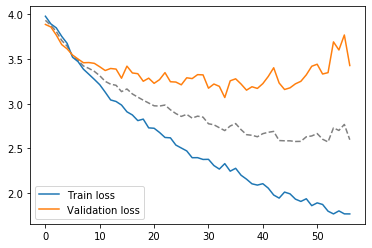

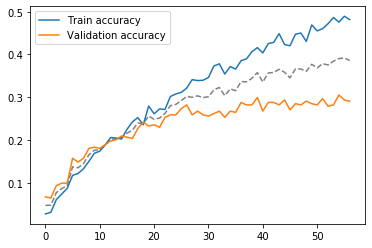

14/14 [==============================] - 0s 3ms/step - loss: 2.9767 - accuracy: 0.2930
Test score: 2.976703643798828
Test accuracy: 0.2930232584476471


In [57]:
h = regularizer_histories['dropout']

for metric in h.history:
    if not metric.startswith('val'):
        for m in h.history:
            if m == "val_{}".format(metric):
                data_m = h.history[metric]
                data_val = h.history['val_{}'.format(metric)]
                
                plt.plot(np.mean([data_m, data_val], axis=0), color="grey", linestyle='dashed')
                plt.plot(data_m, label="Train {}".format(metric))
                plt.plot(data_val, label="Validation {}".format(metric))

                plt.legend()
                plt.show()

out = dropout.evaluate(X_test, y_test)
print('Test score:', out[0])
print('Test accuracy:', out[1])

In [64]:
dropout.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 512)             

In [58]:
prediction = dropout.predict(X_test[0].reshape((1, len(X_test[0]))))
encoder.inverse_transform([prediction[0].argmax()])

array(['oriolus-oriolus'], dtype=object)

In [59]:
X_test[0]

array([-0.56221395,  0.66110626, -0.46766924, -0.16282878, -0.01186368,
       -0.11231048,  0.06995908, -0.08065341,  0.20397619, -0.72772276,
        0.31838295,  0.527863  ,  1.57560184, -0.33962963,  0.5220625 ,
        0.84036009,  0.37222389,  0.54354958, -0.10895592,  0.66963895,
        0.52806306,  0.46752801, -0.82821913,  0.38849534,  0.        ,
       -0.06660586, -0.22681374, -0.77148093])

In [60]:
out = dropout.evaluate(X_test, y_test)
print('Test score:', out[0])
print('Test accuracy:', out[1])

14/14 [==============================] - 0s 3ms/step - loss: 2.9767 - accuracy: 0.2930
Test score: 2.976703643798828
Test accuracy: 0.2930232584476471


In [61]:
y_pred = dropout.predict(X_test).argmax(axis=1)
print(len(y_pred))
print(len(y_test))

430
430


['hippolais-icterina' 'erithacus-rubecula' 'linaria-cannabina'
 'acrocephalus-arundinaceus' 'troglodytes-troglodytes'
 'emberiza-hortulana' 'phoenicurus-phoenicurus' 'emberiza-calandra'
 'luscinia-svecica' 'turdus-philomelos' 'ficedula-hypoleuca'
 'cuculus-canorus' 'sylvia-atricapilla' 'locustella-naevia' 'bubo-bubo'
 'emberiza-cirlus' 'caprimulgus-europaeus' 'carduelis-carduelis'
 'strix-aluco' 'pyrrhula-pyrrhula' 'emberiza-schoeniclus'
 'phylloscopus-sibilatrix' 'phylloscopus-collybita' 'sylvia-borin'
 'hirundo-rustica' 'fringilla-coelebs' 'luscinia-luscinia'
 'carpodacus-erythrinus' 'glaucidium-passerinum' 'sonus-naturalis'
 'luscinia-megarhynchos' 'oriolus-oriolus' 'sylvia-communis'
 'chloris-chloris' 'acrocephalus-schoenobaenus' 'loxia-curvirostra'
 'emberiza-citrinella' 'alauda-arvensis' 'phylloscopus-trochilus'
 'athene-noctua' 'parus-major' 'crex-crex' 'aegolius-funereus'
 'acrocephalus-dumetorum' 'sylvia-curruca' 'turdus-merula'
 'acrocephalus-palustris' 'periparus-ater' 'fice

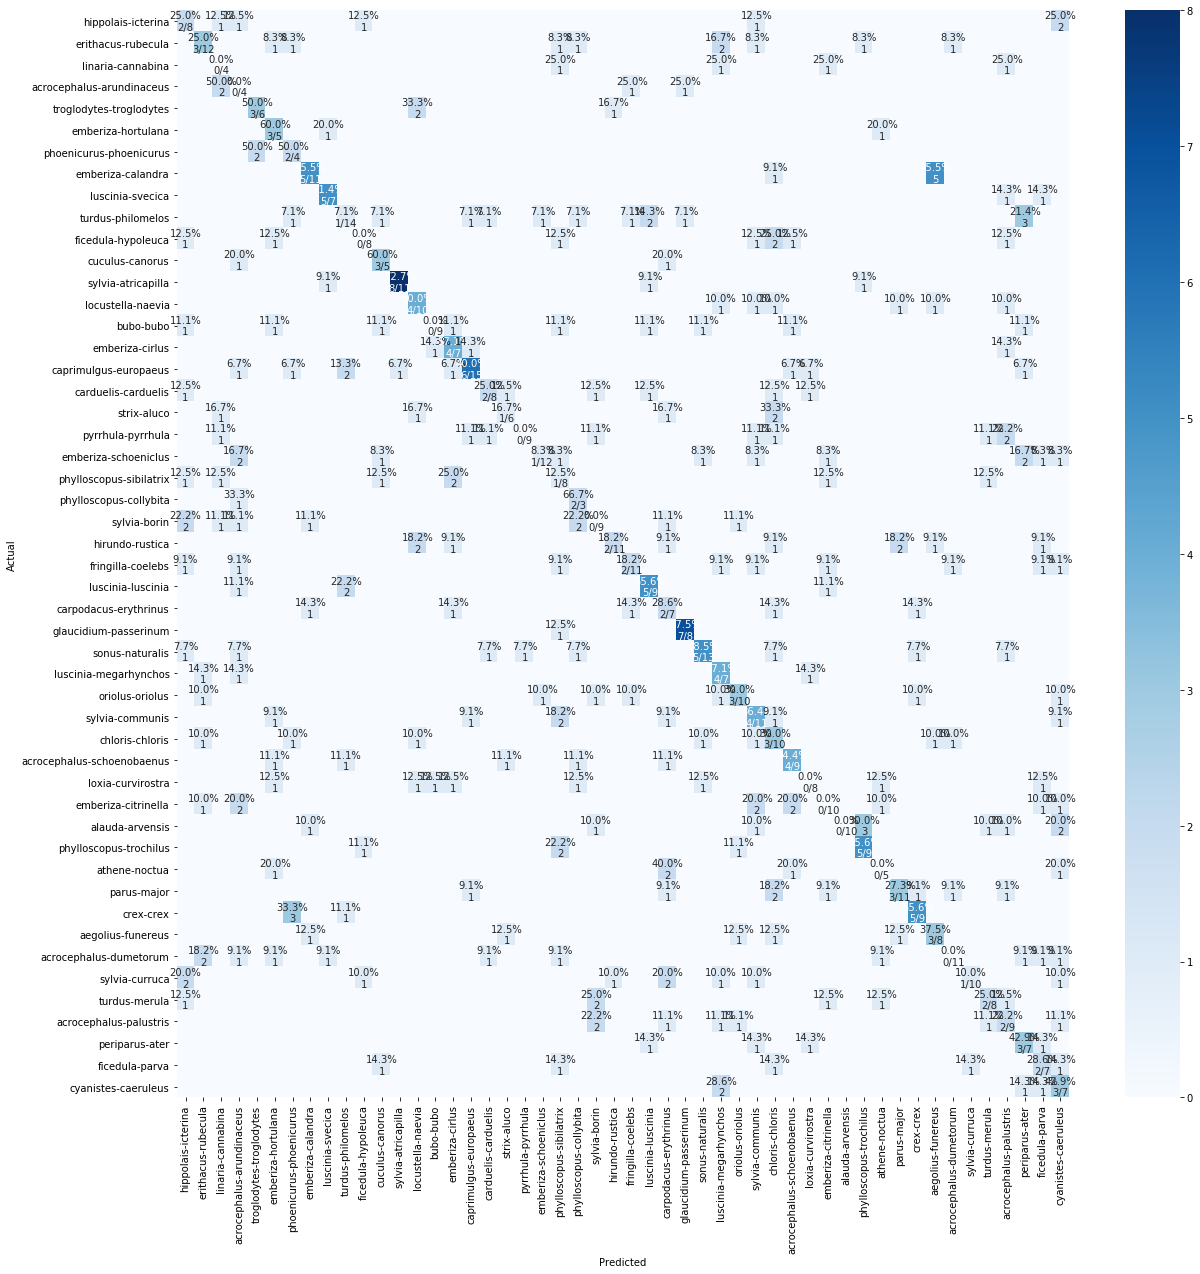

In [62]:
plot_confusion_matrix(y_test, y_pred, [x for x in range(len(birds_classes.unique()))], ymap=birds_classes.unique(), figsize=(20,20))